# Training Models

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from numpy import log, sqrt, log2, ceil, exp
import matplotlib.pyplot as plt
from PreprocessingHelpers import CustomDataset
from Models.Models import Model1, Model2, Model3, Model4, Model5, Model6, Model7
from torch_lr_finder import LRFinder

## Load Data

In [2]:
with open("ProcessedData/train_sequences_padded_dataset_6.pkl", "rb") as file:
    train_sequences_padded_dataset_6 = pickle.load(file)

with open("ProcessedData/train_sequences_padded_dataset_4.pkl", "rb") as file:
    train_sequences_padded_dataset_4 = pickle.load(file)

with open("ProcessedData/vendors_tensor.pkl", "rb") as file:
    vendors_tensor = pickle.load(file)

In [3]:
# Define DataLoaders

batch_size = 32

train_loader_6 = torch.utils.data.DataLoader(dataset=train_sequences_padded_dataset_6, batch_size=batch_size, shuffle=True, drop_last=True)
train_loader_4 = torch.utils.data.DataLoader(dataset=train_sequences_padded_dataset_4, batch_size=batch_size, shuffle=True, drop_last=True)

## Model Blueprint

Our model, creatively named Model1, is the prototype model which we define and test several variants of. At the highest level, our model is supposed to input a sequence of vendor labels the customer has ordered from, plus another vendor label. The output is a score. The higher the score, the more likely the customer is to order from that vendor next.

All of the relevant vendor information is stored within a lookup table based on the vendor id. A vendor id sent into the vendor lookup will result in a 1D tensor representing this vendor. The customer representation is simply the sum of the vendor representations it has recently ordered from. 

The customer and vendor representations are sparse due to the ptag and vtag features which have been one-hot encoded into $d_p$ and $d_v$ dimensional spaces, respectively. These features are independently embedded in $\textrm{ceil}(\textrm{log}_2(d_v))$ and $\textrm{ceil}(\textrm{log}_2(d_p))$ dimensional spaces, respectively via a simple dense layer. The embeddings are concatenated with the other features, and embedded again into customer and vendor embeddings using the same dimensionality reduction scheme. Finally, these embeddings are concatenated and sent through a few dense layers to output a score. Each layer in the network uses an exponential linear unit (ELU) activation function.

<p align="center">
  <img src="Imgs/Recommender1.png" width="1000"/>
</p>

## Margin Ranking Loss

To train our model, we will use a type of ranking loss function. A ranking loss takes as input the scores of a positive sample and a negative sample. A negative sample is simply a vendor which the customer has not recently ordered from. The output is
$$\textrm{loss}(x_+, x_-) = \textrm{max}(0, x_- + 1 - x_+)$$
The loss is $0$ when the positive sample is ranked at least the margin, which here is $1$, higher than or equal to the negative sample.

The idea for this is to train the model to score vendor $R_1$ higher than $R_2$ for a given customer if they prefer $R_1$ more than $R_2$.

In [4]:
def get_negative_samples(low_incl:int, high_excl:int, seqs, dtype=torch.long):
    neg_ids = torch.zeros(size=[seqs.shape[0]], dtype=dtype)
    for i in range(len(seqs)):
        neg_id = torch.randint(low=low_incl, high=high_excl, size=[1]).item()
        while neg_id in seqs[i]:
            neg_id = torch.randint(low=low_incl, high=high_excl, size=[1]).item()
        neg_ids[i] = neg_id
    return neg_ids

## Optimization

From a [blog post by fastai](https://www.fast.ai/2018/07/02/adam-weight-decay), an AdamW optimizer following a [1cycle learning rate scheduler](https://arxiv.org/abs/1708.07120) is the fastest way to train a neural network. 

We will also try other schedulers, such as reducing the learning rate on plateau. 

From [pytorch-lr-finder docs](https://github.com/davidtvs/pytorch-lr-finder):

"The learning rate range test is a test that provides valuable information about the optimal learning rate. During a pre-training run, the learning rate is increased linearly or exponentially between two boundaries. The low initial learning rate allows the network to start converging and as the learning rate is increased it will eventually be too large and the network will diverge ...

"Typically, a good static learning rate can be found half-way on the descending loss curve ... 

"For cyclical learning rates (also detailed in Leslie Smith's paper) where the learning rate is cycled between two boundaries (start_lr, end_lr), the author advises the point at which the loss starts descending and the point at which the loss stops descending or becomes ragged for start_lr and end_lr respectively."

# Give 5 Recommendations

In [5]:
epochs = 201
print_every = 5
save_every = 10

iterations = epochs * len(train_loader_6)
print(f'Iterations: {iterations}')

Iterations: 387729


## Model1

In [13]:
# Tune LR scheduler

d_fc = 64
model = Model1(vendors=vendors_tensor, d_fc=d_fc)
mr_loss = nn.MarginRankingLoss(margin=1.0, reduction='sum')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

100%|██████████| 1000/1000 [00:07<00:00, 134.92it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.43E-04


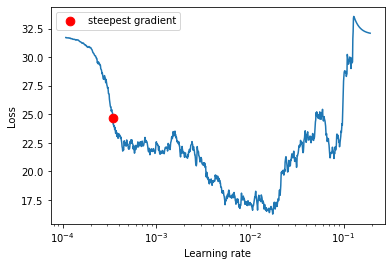

In [13]:
lr_finder = LRFinder(model=model, optimizer=optimizer, criterion=mr_loss, device="cpu")
lr_finder.range_test(train_loader_6, end_lr=2e-1, num_iter=1000)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [14]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, verbose=True)

In [15]:
# Train Model1_64s

for epoch in range(epochs):
    running_loss = 0.0
    for i, (c_seq, v_id) in enumerate(train_loader_6):

        # Generate negative samples
        neg_v_id = get_negative_samples(low_incl=1, high_excl=101, seqs=c_seq)

        # Get scores
        pos_pred = model.forward(c_seq, v_id)
        neg_pred = model.forward(c_seq, neg_v_id)    

        # Compute loss
        mr_loss_target = torch.ones(pos_pred.size())
        batch_loss = mr_loss(pos_pred, neg_pred, mr_loss_target)
        running_loss += batch_loss.item()

        # Calculate gradients
        batch_loss.backward()

        # Update parameters
        optimizer.step()

        # Reset gradients
        optimizer.zero_grad()
    scheduler.step(running_loss)
    
    # Save states and print losses
    if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{epochs-1}]:\tsum(batch_losses) = {running_loss}')

    if epoch % save_every == 0:
        PATH = f"Models/model1_64s_epoch{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': mr_loss,
            }, PATH)

print('Done!')

Epoch [0/200]:	sum(batch_losses) = 29757.56547641754
Epoch [5/200]:	sum(batch_losses) = 20689.701577544212
Epoch [10/200]:	sum(batch_losses) = 19894.281579732895
Epoch [15/200]:	sum(batch_losses) = 19329.314561724663
Epoch [20/200]:	sum(batch_losses) = 19020.60701394081
Epoch [25/200]:	sum(batch_losses) = 18791.27143931389
Epoch [30/200]:	sum(batch_losses) = 18687.402283668518
Epoch [35/200]:	sum(batch_losses) = 18362.830173134804
Epoch [40/200]:	sum(batch_losses) = 18340.50474011898
Epoch [45/200]:	sum(batch_losses) = 18286.499306678772
Epoch [50/200]:	sum(batch_losses) = 17974.241465091705
Epoch [55/200]:	sum(batch_losses) = 18192.17642867565
Epoch [60/200]:	sum(batch_losses) = 18309.59603857994
Epoch    62: reducing learning rate of group 0 to 5.0000e-04.
Epoch [65/200]:	sum(batch_losses) = 17435.818981051445
Epoch [70/200]:	sum(batch_losses) = 17250.176556944847
Epoch [75/200]:	sum(batch_losses) = 17370.070516467094
Epoch [80/200]:	sum(batch_losses) = 17304.035081267357
Epoch [85/2

## Model 2

This model just adds dropout to every non-embedding layer of Model 1.

In [8]:
# Tune LR scheduler

d_fc = 64
model = Model2(vendors=vendors_tensor, d_fc=d_fc)
mr_loss = nn.MarginRankingLoss(margin=1.0, reduction='sum')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)

100%|██████████| 500/500 [00:03<00:00, 127.45it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.16E-02


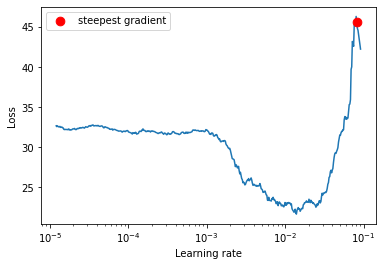

In [9]:
lr_finder = LRFinder(model=model, optimizer=optimizer, criterion=mr_loss, device="cpu")
lr_finder.range_test(train_loader_6, end_lr=1e-1, num_iter=500)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [12]:
3e-2 / 3e-3

10.0

In [10]:
epochs = 100
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, epochs=epochs, steps_per_epoch=len(train_loader), pct_start=0.3, div_factor=5)

In [11]:
# Train Model2s

for epoch in range(epochs):
    running_loss = 0.0
    for i, (c_seq, v_id) in enumerate(train_loader_6):

        # Generate negative samples
        neg_v_id = get_negative_samples(low_incl=1, high_excl=101, seqs=c_seq)

        # Get scores
        pos_pred = model.forward(c_seq, v_id)
        neg_pred = model.forward(c_seq, neg_v_id)

        # Compute loss
        mr_loss_target = torch.ones(pos_pred.size())
        batch_loss = mr_loss(pos_pred, neg_pred, mr_loss_target)
        running_loss += batch_loss.item()

        # Calculate gradients
        batch_loss.backward()

        # Update parameters
        optimizer.step()
        scheduler.step()

        # Reset gradients
        optimizer.zero_grad()
    
    # Save states and print losses
    if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{epochs-1}]:\tsum(batch_losses) = {running_loss}')

    if epoch % save_every == 0:
        PATH = f"Models/model2s_epoch{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': mr_loss,
            }, PATH)

print('Done!')

Epoch [0/100]:	sum(batch_losses) = 43158.924112319946
Epoch [5/100]:	sum(batch_losses) = 31243.122982025146
Epoch [10/100]:	sum(batch_losses) = 31351.658428430557
Epoch [15/100]:	sum(batch_losses) = 31737.354941368103
Epoch [20/100]:	sum(batch_losses) = 32636.565944194794
Epoch [25/100]:	sum(batch_losses) = 33697.40887117386
Epoch [30/100]:	sum(batch_losses) = 34269.0380218029
Epoch [35/100]:	sum(batch_losses) = 39112.63276338577
Epoch [40/100]:	sum(batch_losses) = 33929.08266687393
Epoch [45/100]:	sum(batch_losses) = 34825.95917844772
Epoch [50/100]:	sum(batch_losses) = 38615.45236301422
Epoch [55/100]:	sum(batch_losses) = 34133.12525892258
Epoch [60/100]:	sum(batch_losses) = 32584.111036777496
Epoch [65/100]:	sum(batch_losses) = 31807.789583206177
Epoch [70/100]:	sum(batch_losses) = 31354.02748155594
Epoch [75/100]:	sum(batch_losses) = 30406.962388038635
Epoch [80/100]:	sum(batch_losses) = 29793.210347652435
Epoch [85/100]:	sum(batch_losses) = 29245.65392112732
Epoch [90/100]:	sum(ba

## Model 3

In this model, the embedding layers for the customer and vendor portions share parameters.

In [9]:
# Tune LR scheduler

d_fc = 64
model = Model3(vendors=vendors_tensor, d_fc=d_fc)
mr_loss = nn.MarginRankingLoss(margin=1.0, reduction='sum')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

100%|██████████| 5000/5000 [00:36<00:00, 138.73it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.68E-02


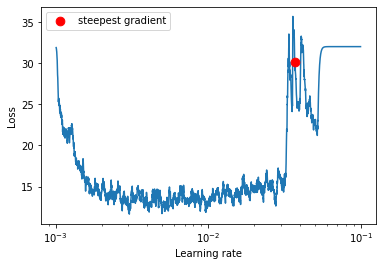

In [12]:
lr_finder = LRFinder(model=model, optimizer=optimizer, criterion=mr_loss, device="cpu")
lr_finder.range_test(train_loader_6, end_lr=1e-1, num_iter=5000)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [10]:
epochs = 200
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, verbose=True)

In [11]:
# Train Model3s

for epoch in range(epochs):
    running_loss = 0.0
    for i, (c_seq, v_id) in enumerate(train_loader_6):

        # Generate negative samples
        neg_v_id = get_negative_samples(low_incl=1, high_excl=101, seqs = c_seq)

        # Get scores
        pos_pred = model.forward(c_seq, v_id)
        neg_pred = model.forward(c_seq, neg_v_id)

        # Compute loss
        mr_loss_target = torch.ones(pos_pred.size())
        batch_loss = mr_loss(pos_pred, neg_pred, mr_loss_target)
        running_loss += batch_loss.item()

        # Update parameters
        batch_loss.backward()
        optimizer.step()

        # Reset gradients
        optimizer.zero_grad()
    scheduler.step(running_loss)
    
    # Save states and print losses
    if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{epochs-1}]: \tsum(batch_losses) = {running_loss}')

    if epoch % save_every == 0:
        PATH = f"Models/model3s_epoch{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': mr_loss,
            }, PATH)

print('Done!')

Epoch [0/400]: 	sum(batch_losses) = 29120.02059483528
Epoch [5/400]: 	sum(batch_losses) = 20344.671631097794
Epoch [10/400]: 	sum(batch_losses) = 19884.660190701485
Epoch [15/400]: 	sum(batch_losses) = 19121.96692842245
Epoch [20/400]: 	sum(batch_losses) = 18940.414473056793
Epoch [25/400]: 	sum(batch_losses) = 18823.748360574245
Epoch [30/400]: 	sum(batch_losses) = 18754.84560275078
Epoch [35/400]: 	sum(batch_losses) = 18522.975008785725
Epoch [40/400]: 	sum(batch_losses) = 18375.935994386673
Epoch [45/400]: 	sum(batch_losses) = 18287.175960063934
Epoch [50/400]: 	sum(batch_losses) = 18274.562456905842
Epoch [55/400]: 	sum(batch_losses) = 18220.755725085735
Epoch [60/400]: 	sum(batch_losses) = 18126.119380414486
Epoch [65/400]: 	sum(batch_losses) = 18125.11615473032
Epoch    71: reducing learning rate of group 0 to 1.0000e-03.
Epoch [70/400]: 	sum(batch_losses) = 18211.24489814043
Epoch [75/400]: 	sum(batch_losses) = 17343.430123806
Epoch [80/400]: 	sum(batch_losses) = 17499.287898719

## Model 4

This model adds an extra dense layer to Model3.

In [19]:
# Tune LR scheduler

d_fc = 64
model = Model4(vendors=vendors_tensor, d_fc=d_fc)
mr_loss = nn.MarginRankingLoss(margin=1.0, reduction='sum')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

 92%|█████████▏| 915/1000 [00:06<00:00, 131.36it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.22E-02


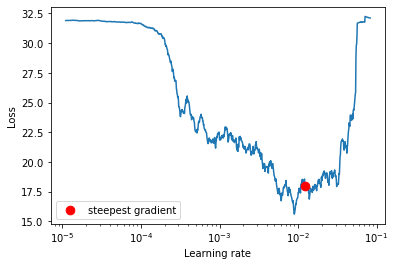

In [16]:
lr_finder = LRFinder(model=model, optimizer=optimizer, criterion=mr_loss, device="cpu")
lr_finder.range_test(train_loader_6, end_lr=2e-1, num_iter=1000)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, verbose=True)

In [21]:
# Train Model4_64s

for epoch in range(epochs):
    running_loss = 0.0
    for i, (c_seq, v_id) in enumerate(train_loader_6):

        # Generate negative samples
        neg_v_id = get_negative_samples(low_incl=1, high_excl=101, seqs=c_seq)

        # Get scores
        pos_pred = model.forward(c_seq, v_id)
        neg_pred = model.forward(c_seq, neg_v_id)    

        # Compute loss
        mr_loss_target = torch.ones(pos_pred.size())
        batch_loss = mr_loss(pos_pred, neg_pred, mr_loss_target)
        running_loss += batch_loss.item()

        # Calculate gradients
        batch_loss.backward()

        # Update parameters
        optimizer.step()

        # Reset gradients
        optimizer.zero_grad()
    scheduler.step(running_loss)
    
    # Save states and print losses
    if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{epochs-1}]:\tsum(batch_losses) = {running_loss}')

    if epoch % save_every == 0:
        PATH = f"Models/give_5/adamw_scheduler/model4_64s_epoch{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': mr_loss,
            }, PATH)
print('Done!')

Epoch [0/200]:	sum(batch_losses) = 28129.19425392151
Epoch [5/200]:	sum(batch_losses) = 21315.00138795376
Epoch [10/200]:	sum(batch_losses) = 20382.007084846497
Epoch [15/200]:	sum(batch_losses) = 19982.816918194294
Epoch [20/200]:	sum(batch_losses) = 19278.930817127228
Epoch [25/200]:	sum(batch_losses) = 19437.344241261482
Epoch [30/200]:	sum(batch_losses) = 19221.377248764038
Epoch [35/200]:	sum(batch_losses) = 19100.791798233986
Epoch [40/200]:	sum(batch_losses) = 18963.12841063738
Epoch [45/200]:	sum(batch_losses) = 18722.865527153015
Epoch [50/200]:	sum(batch_losses) = 18688.91043674946
Epoch [55/200]:	sum(batch_losses) = 18499.78643488884
Epoch [60/200]:	sum(batch_losses) = 18712.00554740429
Epoch [65/200]:	sum(batch_losses) = 18568.735712468624
Epoch [70/200]:	sum(batch_losses) = 18492.518475413322
Epoch [75/200]:	sum(batch_losses) = 18285.123574972153
Epoch [80/200]:	sum(batch_losses) = 18468.827524900436
Epoch [85/200]:	sum(batch_losses) = 18270.90313899517
Epoch [90/200]:	sum

## Model 5
This model, based on Model4, additionally one-hot (or many-hot for the customer) encodes and embeds the vendor ids prior to the dense layers. This is an attempt to capture brand loyalty of customers in our predictions, instead of only going off of vendor data.

In [6]:
# Tune LR scheduler

d_fc = 64
model = Model5(vendors=vendors_tensor, d_fc=d_fc)
mr_loss = nn.MarginRankingLoss(margin=1.0, reduction='sum')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

100%|██████████| 1000/1000 [00:11<00:00, 85.06it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.07E-02


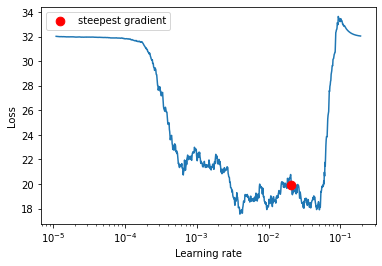

In [7]:
lr_finder = LRFinder(model=model, optimizer=optimizer, criterion=mr_loss, device="cpu")
lr_finder.range_test(train_loader_6, end_lr=2e-1, num_iter=1000)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [8]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, verbose=True)

In [9]:
# Train Model5_64s

for epoch in range(epochs):
    running_loss = 0.0
    for i, (c_seq, v_id) in enumerate(train_loader_6):

        # Generate negative samples
        neg_v_id = get_negative_samples(low_incl=1, high_excl=101, seqs=c_seq)

        # Get scores
        pos_pred = model.forward(c_seq, v_id)
        neg_pred = model.forward(c_seq, neg_v_id)    

        # Compute loss
        mr_loss_target = torch.ones(pos_pred.size())
        batch_loss = mr_loss(pos_pred, neg_pred, mr_loss_target)
        running_loss += batch_loss.item()

        # Calculate gradients
        batch_loss.backward()

        # Update parameters
        optimizer.step()

        # Reset gradients
        optimizer.zero_grad()
    scheduler.step(running_loss)
    
    # Save states and print losses
    if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{epochs-1}]:\tsum(batch_losses) = {running_loss}')

    if epoch % save_every == 0:
        PATH = f"Models/model5_64s_epoch{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': mr_loss,
            }, PATH)
print('Done!')

Epoch [0/200]:	sum(batch_losses) = 27844.59224843979
Epoch [5/200]:	sum(batch_losses) = 18968.535617351532
Epoch [10/200]:	sum(batch_losses) = 17985.282943367958
Epoch [15/200]:	sum(batch_losses) = 17385.153907120228
Epoch [20/200]:	sum(batch_losses) = 16945.887817263603
Epoch [25/200]:	sum(batch_losses) = 16605.721211016178
Epoch [30/200]:	sum(batch_losses) = 16453.010238826275
Epoch [35/200]:	sum(batch_losses) = 16281.14062488079
Epoch [40/200]:	sum(batch_losses) = 16217.138749420643
Epoch [45/200]:	sum(batch_losses) = 16208.009096503258
Epoch [50/200]:	sum(batch_losses) = 16160.969505667686
Epoch [55/200]:	sum(batch_losses) = 15819.30912220478
Epoch [60/200]:	sum(batch_losses) = 15807.897784173489
Epoch [65/200]:	sum(batch_losses) = 15639.531532347202
Epoch [70/200]:	sum(batch_losses) = 15620.403274357319
Epoch [75/200]:	sum(batch_losses) = 15746.234154105186
Epoch [80/200]:	sum(batch_losses) = 15436.185511767864
Epoch [85/200]:	sum(batch_losses) = 15554.782567024231
Epoch    88: re

## Model6
This model, based on Model5, changed how aggregation of customer data is performed. A customer is now the mean of its past non-null orders instead of the sum. This is an attempt to make stronger predictions about new customers. 

In [18]:
# Tune LR scheduler

d_fc = 64
model = Model6(vendors=vendors_tensor, d_fc=d_fc)
mr_loss = nn.MarginRankingLoss(margin=1.0, reduction='sum')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

100%|██████████| 5000/5000 [00:42<00:00, 117.74it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.71E-04


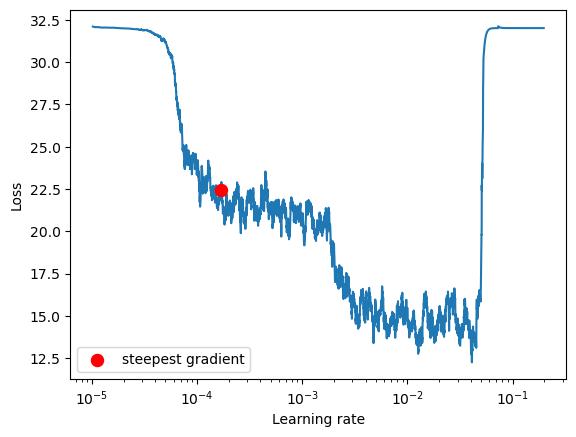

In [7]:
lr_finder = LRFinder(model=model, optimizer=optimizer, criterion=mr_loss, device="cpu")
lr_finder.range_test(train_loader_6, end_lr=2e-1, num_iter=5000)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [19]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.6, verbose=True)

In [20]:
# Train Model6_64s

epochs=301

for epoch in range(epochs):
    running_loss = 0.0
    for i, (c_seq, v_id) in enumerate(train_loader_6):

        # Generate negative samples
        neg_v_id = get_negative_samples(low_incl=1, high_excl=101, seqs=c_seq)

        # Get scores
        pos_pred = model.forward(c_seq, v_id)
        neg_pred = model.forward(c_seq, neg_v_id)    

        # Compute loss
        mr_loss_target = torch.ones(pos_pred.size())
        batch_loss = mr_loss(pos_pred, neg_pred, mr_loss_target)
        running_loss += batch_loss.item()

        # Calculate gradients
        batch_loss.backward()

        # Update parameters
        optimizer.step()

        # Reset gradients
        optimizer.zero_grad()
    scheduler.step(running_loss)
    
    # Save states and print losses
    if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{epochs-1}]:\tsum(batch_losses) = {running_loss}')

    if epoch % save_every == 0:
        PATH = f"Models/give_5/adamw_scheduler/model6_64s_epoch{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': mr_loss,
            }, PATH)
print('Done!')

Epoch [0/300]:	sum(batch_losses) = 29597.368710517883
Epoch [5/300]:	sum(batch_losses) = 19158.238761782646
Epoch [10/300]:	sum(batch_losses) = 18171.381213605404
Epoch [15/300]:	sum(batch_losses) = 17640.512716650963
Epoch [20/300]:	sum(batch_losses) = 17258.688378453255
Epoch [25/300]:	sum(batch_losses) = 16864.554782271385
Epoch [30/300]:	sum(batch_losses) = 16529.873284220695
Epoch [35/300]:	sum(batch_losses) = 16350.882558882236
Epoch [40/300]:	sum(batch_losses) = 16225.178659975529
Epoch [45/300]:	sum(batch_losses) = 16033.875608325005
Epoch [50/300]:	sum(batch_losses) = 15848.642664194107
Epoch [55/300]:	sum(batch_losses) = 15968.159444391727
Epoch [60/300]:	sum(batch_losses) = 15808.690801262856
Epoch [65/300]:	sum(batch_losses) = 15649.962412536144
Epoch [70/300]:	sum(batch_losses) = 15668.268162846565
Epoch [75/300]:	sum(batch_losses) = 15660.268075823784
Epoch [80/300]:	sum(batch_losses) = 15511.166795253754
Epoch [85/300]:	sum(batch_losses) = 15299.766474843025
Epoch [90/30

## Model7

This model is based on Model6, but removes the embedding of the vendor ids (the whole point of brand loyalty is to consider the vendors to be distinct and not learn similarities between them). 

### Model7_64

In [10]:
# Tune LR scheduler

d_fc = 64
model = Model7(vendors=vendors_tensor, d_fc=d_fc)
mr_loss = nn.MarginRankingLoss(margin=1.0, reduction='sum')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

 91%|█████████ | 4552/5000 [00:36<00:03, 123.67it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.20E-02


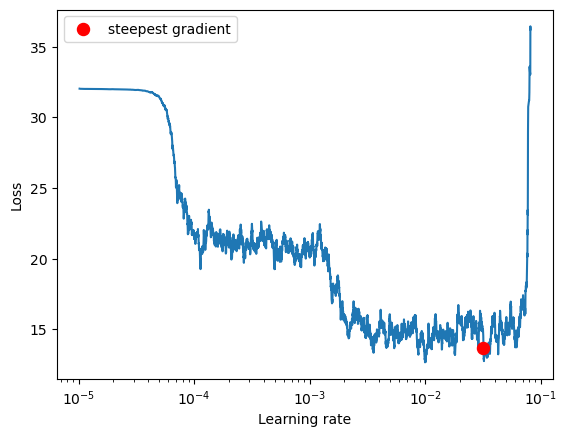

In [7]:
lr_finder = LRFinder(model=model, optimizer=optimizer, criterion=mr_loss, device="cpu")
lr_finder.range_test(train_loader_6, end_lr=2e-1, num_iter=5000)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, verbose=True)

In [12]:
# Train Model7_64s

epochs=201

for epoch in range(epochs):
    running_loss = 0.0
    for i, (c_seq, v_id) in enumerate(train_loader_6):

        # Generate negative samples
        neg_v_id = get_negative_samples(low_incl=1, high_excl=101, seqs=c_seq)

        # Get scores
        pos_pred = model.forward(c_seq, v_id)
        neg_pred = model.forward(c_seq, neg_v_id)    

        # Compute loss
        mr_loss_target = torch.ones(pos_pred.size())
        batch_loss = mr_loss(pos_pred, neg_pred, mr_loss_target)
        running_loss += batch_loss.item()

        # Calculate gradients
        batch_loss.backward()

        # Update parameters
        optimizer.step()

        # Reset gradients
        optimizer.zero_grad()
    scheduler.step(running_loss)
    
    # Save states and print losses
    if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{epochs-1}]:\tsum(batch_losses) = {running_loss}')

    if epoch % save_every == 0:
        PATH = f"Models/give_5/adamw_scheduler/model7_64s_epoch{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': mr_loss,
            }, PATH)
print('Done!')

Epoch [0/200]:	sum(batch_losses) = 29666.523149728775
Epoch [5/200]:	sum(batch_losses) = 16542.81736880541
Epoch [10/200]:	sum(batch_losses) = 15083.996479213238
Epoch [15/200]:	sum(batch_losses) = 14543.945099055767
Epoch [20/200]:	sum(batch_losses) = 13977.005359828472
Epoch [25/200]:	sum(batch_losses) = 13511.057117581367
Epoch [30/200]:	sum(batch_losses) = 13432.720164179802
Epoch [35/200]:	sum(batch_losses) = 13083.677465677261
Epoch [40/200]:	sum(batch_losses) = 13228.531078398228
Epoch [45/200]:	sum(batch_losses) = 12952.862706124783
Epoch [50/200]:	sum(batch_losses) = 12862.687612771988
Epoch [55/200]:	sum(batch_losses) = 12443.007344186306
Epoch [60/200]:	sum(batch_losses) = 12272.992500066757
Epoch [65/200]:	sum(batch_losses) = 12399.75846928358
Epoch [70/200]:	sum(batch_losses) = 12241.42978990078
Epoch [75/200]:	sum(batch_losses) = 12314.409718453884
Epoch [80/200]:	sum(batch_losses) = 12035.487335681915
Epoch [85/200]:	sum(batch_losses) = 12160.178259134293
Epoch [90/200]:

### Model7_128

In [13]:
# Tune LR scheduler

d_fc = 128
model = Model7(vendors=vendors_tensor, d_fc=d_fc)
mr_loss = nn.MarginRankingLoss(margin=1.0, reduction='sum')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

 86%|████████▌ | 4290/5000 [00:44<00:07, 95.37it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.62E-04


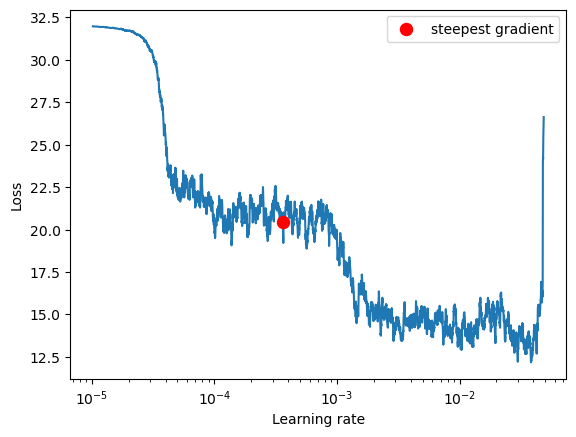

In [14]:
lr_finder = LRFinder(model=model, optimizer=optimizer, criterion=mr_loss, device="cpu")
lr_finder.range_test(train_loader_6, end_lr=2e-1, num_iter=5000)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, verbose=True)

In [16]:
# Train Model7_128s

epochs=201

for epoch in range(epochs):
    running_loss = 0.0
    for i, (c_seq, v_id) in enumerate(train_loader_6):

        # Generate negative samples
        neg_v_id = get_negative_samples(low_incl=1, high_excl=101, seqs=c_seq)

        # Get scores
        pos_pred = model.forward(c_seq, v_id)
        neg_pred = model.forward(c_seq, neg_v_id)    

        # Compute loss
        mr_loss_target = torch.ones(pos_pred.size())
        batch_loss = mr_loss(pos_pred, neg_pred, mr_loss_target)
        running_loss += batch_loss.item()

        # Calculate gradients
        batch_loss.backward()

        # Update parameters
        optimizer.step()

        # Reset gradients
        optimizer.zero_grad()
    scheduler.step(running_loss)
    
    # Save states and print losses
    if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{epochs-1}]:\tsum(batch_losses) = {running_loss}')

    if epoch % save_every == 0:
        PATH = f"Models/give_5/adamw_scheduler/model7_128s_epoch{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': mr_loss,
            }, PATH)
print('Done!')

Epoch [0/200]:	sum(batch_losses) = 29052.219747662544
Epoch [5/200]:	sum(batch_losses) = 16304.291054189205
Epoch [10/200]:	sum(batch_losses) = 14713.03987133503
Epoch [15/200]:	sum(batch_losses) = 13871.794685542583
Epoch [20/200]:	sum(batch_losses) = 13350.795328199863
Epoch [25/200]:	sum(batch_losses) = 12794.365574717522
Epoch [30/200]:	sum(batch_losses) = 12458.186178386211
Epoch [35/200]:	sum(batch_losses) = 11965.773218989372
Epoch [40/200]:	sum(batch_losses) = 11760.021570146084
Epoch [45/200]:	sum(batch_losses) = 11620.446868300438
Epoch [50/200]:	sum(batch_losses) = 11632.775375843048
Epoch [55/200]:	sum(batch_losses) = 11408.79472064972
Epoch [60/200]:	sum(batch_losses) = 11134.870168566704
Epoch [65/200]:	sum(batch_losses) = 11070.52454996109
Epoch [70/200]:	sum(batch_losses) = 10664.503724396229
Epoch [75/200]:	sum(batch_losses) = 10736.414643108845
Epoch [80/200]:	sum(batch_losses) = 10804.495998501778
Epoch [85/200]:	sum(batch_losses) = 10910.834501326084
Epoch [90/200]:

### Model7_256

In [17]:
# Tune LR scheduler

d_fc = 256
model = Model7(vendors=vendors_tensor, d_fc=d_fc)
mr_loss = nn.MarginRankingLoss(margin=1.0, reduction='sum')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

 88%|████████▊ | 4387/5000 [00:52<00:07, 83.80it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.62E-02


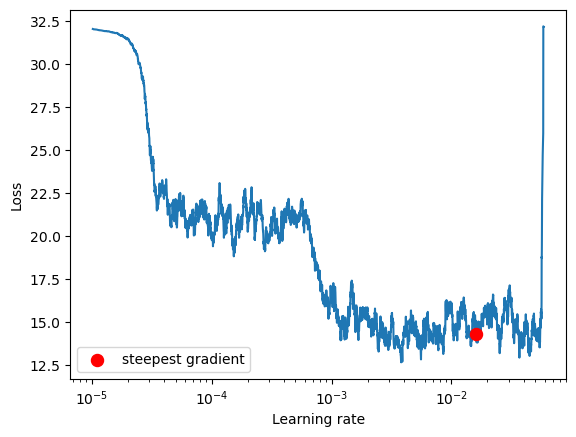

In [18]:
lr_finder = LRFinder(model=model, optimizer=optimizer, criterion=mr_loss, device="cpu")
lr_finder.range_test(train_loader_6, end_lr=2e-1, num_iter=5000)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, verbose=True)

In [21]:
# Train Model7_128s

epochs=201

for epoch in range(epochs):
    running_loss = 0.0
    for i, (c_seq, v_id) in enumerate(train_loader_6):

        # Generate negative samples
        neg_v_id = get_negative_samples(low_incl=1, high_excl=101, seqs=c_seq)

        # Get scores
        pos_pred = model.forward(c_seq, v_id)
        neg_pred = model.forward(c_seq, neg_v_id)    

        # Compute loss
        mr_loss_target = torch.ones(pos_pred.size())
        batch_loss = mr_loss(pos_pred, neg_pred, mr_loss_target)
        running_loss += batch_loss.item()

        # Calculate gradients
        batch_loss.backward()

        # Update parameters
        optimizer.step()

        # Reset gradients
        optimizer.zero_grad()
    scheduler.step(running_loss)
    
    # Save states and print losses
    if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{epochs-1}]:\tsum(batch_losses) = {running_loss}')

    if epoch % save_every == 0:
        PATH = f"Models/give_5/adamw_scheduler/model7_256s_epoch{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': mr_loss,
            }, PATH)
print('Done!')

Epoch [0/200]:	sum(batch_losses) = 27622.844071149826
Epoch [5/200]:	sum(batch_losses) = 15853.196903049946
Epoch [10/200]:	sum(batch_losses) = 14499.935485303402
Epoch [15/200]:	sum(batch_losses) = 13655.093667984009
Epoch [20/200]:	sum(batch_losses) = 12721.672129273415
Epoch [25/200]:	sum(batch_losses) = 12322.76597571373
Epoch [30/200]:	sum(batch_losses) = 12802.56866967678
Epoch [35/200]:	sum(batch_losses) = 11510.209562301636
Epoch [40/200]:	sum(batch_losses) = 11348.295449495316
Epoch [45/200]:	sum(batch_losses) = 11052.159798622131
Epoch [50/200]:	sum(batch_losses) = 10748.764335870743
Epoch [55/200]:	sum(batch_losses) = 10568.423379659653
Epoch [60/200]:	sum(batch_losses) = 10340.180102109909
Epoch [65/200]:	sum(batch_losses) = 10150.205479979515
Epoch [70/200]:	sum(batch_losses) = 9964.49943447113
Epoch [75/200]:	sum(batch_losses) = 9780.688783407211
Epoch [80/200]:	sum(batch_losses) = 9819.644921779633
Epoch [85/200]:	sum(batch_losses) = 9476.952054262161
Epoch [90/200]:	sum

# Give 3 Recommendations

In [10]:
epochs = 201
print_every = 5
save_every = 10

iterations = epochs * len(train_loader_4)
print(f'Iterations: {iterations}')

Iterations: 387729


## Model 1

In [9]:
# Tune LR scheduler

d_fc = 64
model = Model1(vendors=vendors_tensor, d_fc=d_fc)
mr_loss = nn.MarginRankingLoss(margin=1.0, reduction='sum')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

 98%|█████████▊| 982/1000 [00:07<00:00, 129.17it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.22E-02


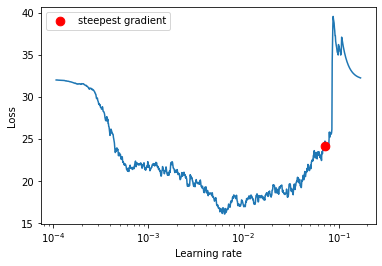

In [10]:
lr_finder = LRFinder(model=model, optimizer=optimizer, criterion=mr_loss, device="cpu")
lr_finder.range_test(train_loader_4, end_lr=2e-1, num_iter=1000)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, verbose=True)

In [12]:
# Train Model1_64s

for epoch in range(epochs):
    running_loss = 0.0
    for i, (c_seq, v_id) in enumerate(train_loader_4):

        # Generate negative samples
        neg_v_id = get_negative_samples(low_incl=1, high_excl=101, seqs=c_seq)

        # Get scores
        pos_pred = model.forward(c_seq, v_id)
        neg_pred = model.forward(c_seq, neg_v_id)    

        # Compute loss
        mr_loss_target = torch.ones(pos_pred.size())
        batch_loss = mr_loss(pos_pred, neg_pred, mr_loss_target)
        running_loss += batch_loss.item()

        # Calculate gradients
        batch_loss.backward()

        # Update parameters
        optimizer.step()

        # Reset gradients
        optimizer.zero_grad()
    scheduler.step(running_loss)
    
    # Save states and print losses
    if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{epochs-1}]:\tsum(batch_losses) = {running_loss}')

    if epoch % save_every == 0:
        PATH = f"Models/model1_64s_3r_epoch{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': mr_loss,
            }, PATH)

print('Done!')

Epoch [0/200]:	sum(batch_losses) = 29382.026234149933
Epoch [5/200]:	sum(batch_losses) = 21058.934849739075
Epoch [10/200]:	sum(batch_losses) = 20461.587405085564
Epoch [15/200]:	sum(batch_losses) = 20050.108036637306
Epoch [20/200]:	sum(batch_losses) = 19576.373019337654
Epoch [25/200]:	sum(batch_losses) = 19607.38896328211
Epoch [30/200]:	sum(batch_losses) = 19643.624164700508
Epoch [35/200]:	sum(batch_losses) = 19181.673806786537
Epoch [40/200]:	sum(batch_losses) = 19186.17053937912
Epoch    44: reducing learning rate of group 0 to 1.5000e-03.
Epoch [45/200]:	sum(batch_losses) = 18596.77744305134
Epoch [50/200]:	sum(batch_losses) = 18477.523526072502
Epoch [55/200]:	sum(batch_losses) = 18313.329267919064
Epoch [60/200]:	sum(batch_losses) = 18250.19164222479
Epoch [65/200]:	sum(batch_losses) = 18083.04153096676
Epoch [70/200]:	sum(batch_losses) = 18109.442662000656
Epoch [75/200]:	sum(batch_losses) = 18109.217709064484
Epoch [80/200]:	sum(batch_losses) = 18101.787080407143
Epoch [85/

## Model 2

This model just adds dropout to every non-embedding layer of Model 1.

In [13]:
# Tune LR scheduler

d_fc = 64
model = Model2(vendors=vendors_tensor, d_fc=d_fc)
mr_loss = nn.MarginRankingLoss(margin=1.0, reduction='sum')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)

100%|██████████| 500/500 [00:04<00:00, 118.86it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.54E-03


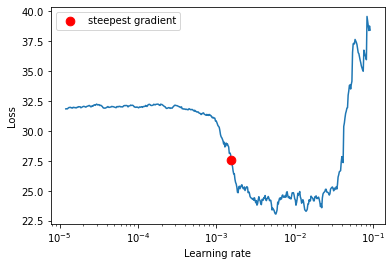

In [14]:
lr_finder = LRFinder(model=model, optimizer=optimizer, criterion=mr_loss, device="cpu")
lr_finder.range_test(train_loader_4, end_lr=1e-1, num_iter=500)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [12]:
3e-2 / 3e-3

10.0

In [15]:
epochs = 200
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, verbose=True)

In [16]:
# Train Model2s

for epoch in range(epochs):
    running_loss = 0.0
    for i, (c_seq, v_id) in enumerate(train_loader_4):

        # Generate negative samples
        neg_v_id = get_negative_samples(low_incl=1, high_excl=101, seqs=c_seq)

        # Get scores
        pos_pred = model.forward(c_seq, v_id)
        neg_pred = model.forward(c_seq, neg_v_id)

        # Compute loss
        mr_loss_target = torch.ones(pos_pred.size())
        batch_loss = mr_loss(pos_pred, neg_pred, mr_loss_target)
        running_loss += batch_loss.item()

        # Calculate gradients
        batch_loss.backward()

        # Update parameters
        optimizer.step()

        # Reset gradients
        optimizer.zero_grad()
    scheduler.step(running_loss)
    
    # Save states and print losses
    if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{epochs-1}]:\tsum(batch_losses) = {running_loss}')

    if epoch % save_every == 0:
        PATH = f"Models/model2_64s_3r_epoch{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': mr_loss,
            }, PATH)

print('Done!')

Epoch [0/200]:	sum(batch_losses) = 41153.06204652786
Epoch [5/200]:	sum(batch_losses) = 30396.481813430786
Epoch [10/200]:	sum(batch_losses) = 29711.53877878189
Epoch [15/200]:	sum(batch_losses) = 29661.55751848221
Epoch [20/200]:	sum(batch_losses) = 29293.33169746399
Epoch [25/200]:	sum(batch_losses) = 29059.329626083374
Epoch [30/200]:	sum(batch_losses) = 29089.346237659454
Epoch [35/200]:	sum(batch_losses) = 29326.610050201416
Epoch [40/200]:	sum(batch_losses) = 28963.573987960815
Epoch [45/200]:	sum(batch_losses) = 28888.65067768097
Epoch [50/200]:	sum(batch_losses) = 28863.05599975586
Epoch    56: reducing learning rate of group 0 to 1.0000e-03.
Epoch [55/200]:	sum(batch_losses) = 28973.01103925705
Epoch [60/200]:	sum(batch_losses) = 27914.689883947372
Epoch [65/200]:	sum(batch_losses) = 27886.104482889175
Epoch [70/200]:	sum(batch_losses) = 28148.97920036316
Epoch [75/200]:	sum(batch_losses) = 27879.14325284958
Epoch [80/200]:	sum(batch_losses) = 27944.53309583664
Epoch [85/200]:

## Model 3

In this model, the embedding layers for the customer and vendor portions share parameters.

In [24]:
# Tune LR scheduler

d_fc = 64
model = Model3(vendors=vendors_tensor, d_fc=d_fc)
mr_loss = nn.MarginRankingLoss(margin=1.0, reduction='sum')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

 81%|████████  | 4045/5000 [00:36<00:08, 109.49it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.08E-03


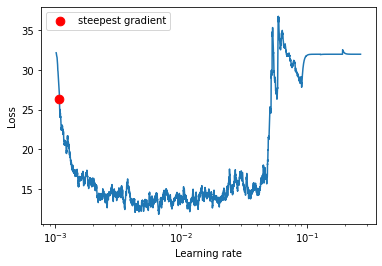

In [25]:
lr_finder = LRFinder(model=model, optimizer=optimizer, criterion=mr_loss, device="cpu")
lr_finder.range_test(train_loader_4, end_lr=1, num_iter=5000)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [26]:
epochs = 201
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, verbose=True)

In [27]:
# Train Model3s

for epoch in range(epochs):
    running_loss = 0.0
    for i, (c_seq, v_id) in enumerate(train_loader_4):

        # Generate negative samples
        neg_v_id = get_negative_samples(low_incl=1, high_excl=101, seqs = c_seq)

        # Get scores
        pos_pred = model.forward(c_seq, v_id)
        neg_pred = model.forward(c_seq, neg_v_id)

        # Compute loss
        mr_loss_target = torch.ones(pos_pred.size())
        batch_loss = mr_loss(pos_pred, neg_pred, mr_loss_target)
        running_loss += batch_loss.item()

        # Update parameters
        batch_loss.backward()
        optimizer.step()

        # Reset gradients
        optimizer.zero_grad()
    scheduler.step(running_loss)
    
    # Save states and print losses
    if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{epochs-1}]: \tsum(batch_losses) = {running_loss}')

    if epoch % save_every == 0:
        PATH = f"Models/model3s_3r_epoch{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': mr_loss,
            }, PATH)

print('Done!')

Epoch [0/200]: 	sum(batch_losses) = 28093.047201633453
Epoch [5/200]: 	sum(batch_losses) = 21052.865592718124
Epoch [10/200]: 	sum(batch_losses) = 19804.692729711533
Epoch [15/200]: 	sum(batch_losses) = 19369.133969783783
Epoch [20/200]: 	sum(batch_losses) = 19032.185120105743
Epoch [25/200]: 	sum(batch_losses) = 19408.6988632679
Epoch [30/200]: 	sum(batch_losses) = 19044.25615942478
Epoch [35/200]: 	sum(batch_losses) = 18885.14574098587
Epoch [40/200]: 	sum(batch_losses) = 18895.292837440968
Epoch [45/200]: 	sum(batch_losses) = 18604.20952320099
Epoch [50/200]: 	sum(batch_losses) = 18620.831396579742
Epoch    55: reducing learning rate of group 0 to 1.0000e-03.
Epoch [55/200]: 	sum(batch_losses) = 18327.879315555096
Epoch [60/200]: 	sum(batch_losses) = 17968.19418168068
Epoch [65/200]: 	sum(batch_losses) = 17800.203880786896
Epoch    70: reducing learning rate of group 0 to 5.0000e-04.
Epoch [70/200]: 	sum(batch_losses) = 17618.91597020626
Epoch [75/200]: 	sum(batch_losses) = 17377.81

## Model 4

In [19]:
# Tune LR scheduler

d_fc = 64
model = Model4(vendors=vendors_tensor, d_fc=d_fc)
mr_loss = nn.MarginRankingLoss(margin=1.0, reduction='sum')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

100%|██████████| 1000/1000 [00:13<00:00, 75.87it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.59E-03


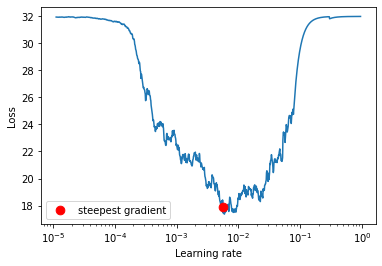

In [15]:
lr_finder = LRFinder(model=model, optimizer=optimizer, criterion=mr_loss, device="cpu")
lr_finder.range_test(train_loader_4, end_lr=1, num_iter=1000)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [20]:
epochs = 201
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, verbose=True)

In [21]:
# Train Model4s

for epoch in range(epochs):
    running_loss = 0.0
    for i, (c_seq, v_id) in enumerate(train_loader_4):

        # Generate negative samples
        neg_v_id = get_negative_samples(low_incl=1, high_excl=101, seqs = c_seq)

        # Get scores
        pos_pred = model.forward(c_seq, v_id)
        neg_pred = model.forward(c_seq, neg_v_id)

        # Compute loss
        mr_loss_target = torch.ones(pos_pred.size())
        batch_loss = mr_loss(pos_pred, neg_pred, mr_loss_target)
        running_loss += batch_loss.item()

        # Update parameters
        batch_loss.backward()
        optimizer.step()

        # Reset gradients
        optimizer.zero_grad()
    scheduler.step(running_loss)
    
    # Save states and print losses
    if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{epochs-1}]: \tsum(batch_losses) = {running_loss}')

    if epoch % save_every == 0:
        PATH = f"Models/give_3/model4s_3r_epoch{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': mr_loss,
            }, PATH)

print('Done!')

Epoch [0/200]: 	sum(batch_losses) = 27532.089481830597
Epoch [5/200]: 	sum(batch_losses) = 21320.632647514343
Epoch [10/200]: 	sum(batch_losses) = 20692.923611998558
Epoch [15/200]: 	sum(batch_losses) = 20480.195014476776
Epoch [20/200]: 	sum(batch_losses) = 20068.915501713753
Epoch [25/200]: 	sum(batch_losses) = 20278.694372057915
Epoch [30/200]: 	sum(batch_losses) = 19805.13705456257
Epoch [35/200]: 	sum(batch_losses) = 20010.9423494339
Epoch [40/200]: 	sum(batch_losses) = 19705.045112490654
Epoch [45/200]: 	sum(batch_losses) = 19324.154085993767
Epoch [50/200]: 	sum(batch_losses) = 19456.866082668304
Epoch [55/200]: 	sum(batch_losses) = 19508.187916874886
Epoch [60/200]: 	sum(batch_losses) = 19134.392874479294
Epoch [65/200]: 	sum(batch_losses) = 19045.774256944656
Epoch [70/200]: 	sum(batch_losses) = 18894.981684803963
Epoch [75/200]: 	sum(batch_losses) = 19022.933003425598
Epoch [80/200]: 	sum(batch_losses) = 19128.109461784363
Epoch [85/200]: 	sum(batch_losses) = 19130.5864566564

## Model 5

In [24]:
# Tune LR scheduler

d_fc = 64
model = Model5(vendors=vendors_tensor, d_fc=d_fc)
mr_loss = nn.MarginRankingLoss(margin=1.0, reduction='sum')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

In [ ]:
lr_finder = LRFinder(model=model, optimizer=optimizer, criterion=mr_loss, device="cpu")
lr_finder.range_test(train_loader_4, end_lr=1, num_iter=5000)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [26]:
epochs = 201
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, verbose=True)

In [ ]:
# Train Model5s

for epoch in range(epochs):
    running_loss = 0.0
    for i, (c_seq, v_id) in enumerate(train_loader_4):

        # Generate negative samples
        neg_v_id = get_negative_samples(low_incl=1, high_excl=101, seqs = c_seq)

        # Get scores
        pos_pred = model.forward(c_seq, v_id)
        neg_pred = model.forward(c_seq, neg_v_id)

        # Compute loss
        mr_loss_target = torch.ones(pos_pred.size())
        batch_loss = mr_loss(pos_pred, neg_pred, mr_loss_target)
        running_loss += batch_loss.item()

        # Update parameters
        batch_loss.backward()
        optimizer.step()

        # Reset gradients
        optimizer.zero_grad()
    scheduler.step(running_loss)
    
    # Save states and print losses
    if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{epochs-1}]: \tsum(batch_losses) = {running_loss}')

    if epoch % save_every == 0:
        PATH = f"Models/give_3/model5s_3r_epoch{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': mr_loss,
            }, PATH)

print('Done!')

# Check

In [ ]:
print(f'num batches: {len(train_losses1)}')
print(f'batches per epoch: {len(train_losses1) // epochs}')

In [ ]:
plt.figure(figsize=(30, 10))
plt.plot(range(len(train_losses1)), train_losses1, label="Model1")
plt.plot(range(len(train_losses2)), train_losses2, label="Model2")
plt.plot(range(len(train_losses3)), train_losses3, label="Model3")
plt.xlabel('Batch #')
plt.ylabel('Batch Loss')
plt.legend()
plt.show()

In [ ]:
with open("ProcessedData/test_sequences_padded_dataset.pkl", "rb") as file:
    test_sequences_padded_dataset = pickle.load(file)

test_loader = torch.utils.data.DataLoader(test_sequences_padded_dataset, batch_size=1)

seq = iter(test_loader).next()[0]
print(seq)
seq = seq.view(1, -1)

In [ ]:
model.eval()

seq = torch.tensor([[28, 28, 28, 28, 28]])

y = torch.ones([100, 1], dtype=torch.long)      # 100 vendors
seq_dupe = y @ seq                              # 100 x 5 matrix
v_ids = torch.arange(start=1, end=101, dtype=torch.long)
rankings = model.forward(c_seq=seq_dupe, v_id=v_ids).view(-1)    
top_k = torch.topk(rankings, 5)[1][:5]          # Essentially argmax for top k
top_k = top_k + 1

print(rankings.sort(descending=True))
print(len(rankings.tolist()))
print(top_k)